In [1]:
import gc
import feather
from pprint import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import pandas as pd

### Fit model on train data

In [2]:
path = '../data-vol-2'
df_train = feather.read_dataframe(f'{path}/Prepared_data/train_filled_na.feather')
print(df_train.shape)
pprint(df_train.columns.to_list())

(20216100, 68)
['building_id',
 'meter',
 'meter_reading',
 'row_id',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'utc',
 'new_floor_count',
 'new_year_built',
 'square_feet_log',
 'is_holiday',
 'weekday_cos',
 'weekday_sin',
 'weekday',
 'hour_cos',
 'hour_sin',
 'year_cos',
 'year_sin',
 'night_time',
 'morning',
 'afternoon',
 'evening',
 'is_day_saving',
 'utc_time',
 'suspicious_1',
 'suspicious_2',
 'suspicious_3',
 'age',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_speed',
 'new_sea_level_pressure',
 'new_dew_temperature',
 'new_wind_speed',
 'new_cloud_coverage',
 'new_precip_depth_1_hr',
 'new_air_temperature',
 'uvIndex',
 'cloudCover',
 'humidity',
 'latitude',
 'longitude',
 'irradiance',
 'irradiance_cloud',
 'feels_like',
 'new_feels_like',
 'altitude',
 'azimuth',
 'radiation',
 'air_temperature_mean_lag72',
 'air_temperature_max_lag72',
 'air_temperature_min_lag72',
 'air

In [6]:
# Filter rows of interest
print(df_train.shape)
df_train.drop(df_train[(
    df_train['suspicious_1']==1) | (df_train['suspicious_2']==1) | (df_train['suspicious_3']==1) ].index, 
              inplace=True)
print(df_train.shape)

# Filter columns of interest
df_train.drop(['row_id',
               'suspicious_1', 
               'suspicious_2', 
               'suspicious_3'], axis=1, inplace=True)
print(df_train.shape)

(20216100, 68)
(18562599, 68)
(18562599, 64)


In [5]:
features_labels = [
    'building_id',
    'year_cos',
    'year_sin',
    'square_feet',
    'meter',
    'air_temperature_mean_lag72',
    'air_temperature_min_lag72',
    'new_floor_count',
    'air_temperature_max_lag72',
    'cloudCover_mean_lag72',
    'weekday_cos'
]

categorical_features = [
    "building_id", 
#     "site_id", 
    "meter", 
#     "primary_use", 
#     "weekday", 
#     "morning", 
#     "afternoon", 
#     "evening",
#     "is_day_saving"
]

In [7]:
# Retrieve target and features
target = np.log1p(df_train["meter_reading"])
features = df_train[features_labels].copy()
print(features.shape, target.shape)
del df_train
gc.collect()

(18562599, 11) (18562599,)


85

In [9]:
d_training = lgb.Dataset(features, 
                         label=target,
                         categorical_feature=categorical_features, 
                         free_raw_data=False)

In [10]:
name = 'test_v18'
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
    "max_depth": -1,
    "tree_learner": "serial",
#     "colsample_bytree": ?,
#     "subsample": ?,
    "max_bin": 255,
#     "boosting_type": ?,    
}

# params = {
#      'objective': 'regression',
#      'metric': 'rmse',
#      'n_jobs': -1,
#      'learning_rate': 0.01,
#      'num_leaves': 256,
#      'max_depth': -1,
#      'tree_learner': 'serial',
#      'colsample_bytree': 0.9,
#      'subsample': 0.5,
#      'max_bin': 50,
#      'verbose': 2,
#      'boosting_type': 'goss',
#      'subsample_freq': 0,
#      'seed': 7,
#      'top_rate': 0.5,
#      'other_rate': 0.4
# }


In [22]:
group = train['site_id'].astype(str) + "_" + (train['utc_time'].dt.month).astype(str)

groupSplit = GroupShuffleSplit(5, test_size=0.2, random_state=7)
folds = groupSplit.split(train[['radiation']],
                         train['meter_reading'],
                         groups=group)

{'objective': 'regression',
 'boosting': 'gbdt',
 'num_leaves': 1280,
 'learning_rate': 0.05,
 'feature_fraction': 0.85,
 'reg_lambda': 2,
 'metric': 'rmse'}

In [11]:
model = lgb.train(
    params, train_set=d_training, valid_sets=[d_training],
    num_boost_round=400, 
    verbose_eval=25, early_stopping_rounds=50)

/Users/pmrc471m/Documents/energy/env_37_energy/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.01774
[50]	training's rmse: 0.795123
[75]	training's rmse: 0.721406
[100]	training's rmse: 0.676938
[125]	training's rmse: 0.641071
[150]	training's rmse: 0.617324
[175]	training's rmse: 0.599862
[200]	training's rmse: 0.587546
[225]	training's rmse: 0.578398
[250]	training's rmse: 0.569967
[275]	training's rmse: 0.562495
[300]	training's rmse: 0.556287
[325]	training's rmse: 0.550749
[350]	training's rmse: 0.545814
[375]	training's rmse: 0.541194
[400]	training's rmse: 0.536974
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.536974


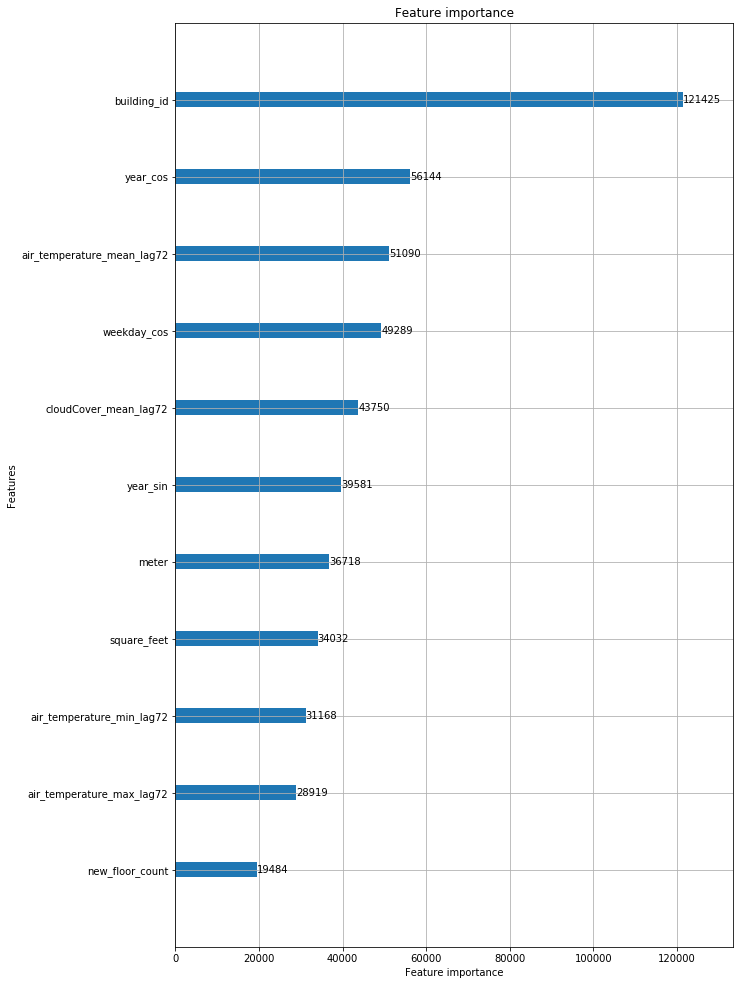

In [12]:
cols = lgb.plot_importance(model, figsize=(10, 17))

In [13]:
del features, target
gc.collect()

0

### Predict on test data

In [14]:
path = '../data-vol-2'
df_test = feather.read_dataframe(f'{path}/Prepared_data/test_filled_na.feather')
df_test = df_test.set_index('row_id')
df_test = df_test.sort_index()
print(df_test.shape)
df_test.head()

(41697600, 63)


,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,utc,new_floor_count,new_year_built,...,air_temperature_std_lag72,cloudCover_mean_lag72,cloudCover_max_lag72,cloudCover_min_lag72,cloudCover_std_lag72,beaufort_scale,wind_direction_cos,wind_direction_sin,new_wind_direction_cos,new_wind_direction_sin
row_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,Education,7432,2008.0,NaN,-4.0,2.398141,2008.0,...,6.226562,0.160645,1.0,0.0,0.297607,2.0,-0.642788,0.766044,-0.642788,0.766044
1,1,0,0,Education,2720,2004.0,NaN,-4.0,2.248431,2004.0,...,6.226562,0.160645,1.0,0.0,0.297607,2.0,-0.642788,0.766044,-0.642788,0.766044
2,2,0,0,Education,5376,1991.0,NaN,-4.0,2.332818,1991.0,...,6.226562,0.160645,1.0,0.0,0.297607,2.0,-0.642788,0.766044,-0.642788,0.766044
3,3,0,0,Education,23685,2002.0,NaN,-4.0,2.914535,2002.0,...,6.226562,0.160645,1.0,0.0,0.297607,2.0,-0.642788,0.766044,-0.642788,0.766044
4,4,0,0,Education,116607,1975.0,NaN,-4.0,5.866873,1975.0,...,6.226562,0.160645,1.0,0.0,0.297607,2.0,-0.642788,0.766044,-0.642788,0.766044


# step = 250000
start = int(time.time())
i = 0
df_test['pred'] = np.nan
predictions = []

while i < df_test.shape[0]:
    print(f"Start : [{i}: {i + step - 1}]")    
    df_subset = df_test.loc[i: (i + step - 1)].copy()
    predictions_ = model.predict(df_subset[model.feature_name()])
    predictions.append(predictions_)     
    i = i + step
    print(f"Total duration at {round(i/df_test.shape[0]*100, 2)} % progress : {round(time.time() - start, 2)}s\n")

start__ = time.time()
predictions__ = np.concatenate(predictions)
df_test.loc[0: (i - 1), 'pred'] = predictions__
print(f"Loc write duration : {round(time.time() - start__, 2)}s")
print(f"Total duration at {round(i/df_test.shape[0]*100, 2)} % progress : {round(time.time() - start, 2)}s\n")

In [16]:
# Process the results
df_results = pd.DataFrame(index=df_test.index)
df_results['meter_reading'] = np.exp(df_test['pred']) - 1
df_results['meter_reading'] = np.where(df_results['meter_reading'].lt(0), 0, df_results['meter_reading'])
print(df_results.shape)
del df_test
gc.collect()
df_results.head()

(41697600, 1)


,meter_reading
row_id,
0,189.055577
1,51.637626
2,3.818167
3,127.415894
4,1151.366210


### Replace test predictions with some leaked data

In [17]:
df_leaked = feather.read_dataframe('../data-vol-2/Leaked/leaked_submission.feather')
print(df_leaked.shape)
df_leaked.set_index('row_id', inplace=True)
df_leaked = df_leaked.dropna()
print(df_leaked.shape)
df_leaked.head()

(11937501, 3)
(8152670, 2)


,site_id,meter_reading
row_id,,
0,0,173.370293
1,0,53.512720
2,0,6.143042
3,0,101.701470
4,0,1141.240666


In [18]:
df_results.loc[df_leaked.index, 'meter_reading'] = df_leaked['meter_reading'].copy()
del df_leaked
gc.collect()
df_results['meter_reading'] = df_results['meter_reading'].round(4)
print(df_results.shape)
df_results.head()

(41697600, 1)


,meter_reading
row_id,
0,173.3703
1,53.5127
2,6.1430
3,101.7015
4,1141.2407


In [19]:
path = '../submission'
df_results.to_csv(f'{path}/submission_{name}_imputed_filled_na.csv')
del df_results
gc.collect()

7

In [20]:
df_results_ = pd.read_csv(f'{path}/submission_{name}_imputed_filled_na.csv')
df_results_.shape

(41697600, 2)